In [1]:
import torch
import torch.nn as nn
import clip
from PIL import Image
import pandas as pd
import requests
import os.path as osp
import pickle
import random
import numpy as np
from pathlib import Path
import sys
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import shutil

c:\users\aphri\miniconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [132]:
dataset_path = "data/cleaned_target_furniture_dataset.csv"
pickle_path = "C:/Users/aphri/Documents/t0002/work/data/w210_data/data3_pickle"
image_pickle_path = "C:/Users/aphri/Documents/t0002/work/data/w210_data/data3_image_pickle"

Path(pickle_path).mkdir(parents=True, exist_ok=True)
Path(image_pickle_path).mkdir(parents=True, exist_ok=True)

In [3]:
def read_pickle(dir):
    with open(dir, 'rb') as handle:
        b = pickle.load(handle)
    return b


def write_pickle(dir, data):
    with open(dir, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
def image_path(uid):
    return osp.join(image_storage, f"{uid}.jpg")

In [97]:
def combine_category(x):
    res = x["sub_category_1"]
    if not pd.isna(x["sub_category_2"]):
        res += ", " + x["sub_category_2"]
    if not pd.isna(x["sub_category_3"]):
        res += ", " + x["sub_category_3"]
    if not pd.isna(x["colors"]):
        res += ", " + x["colors"]
    
    return res

In [112]:
def combine_title(x):
    res = x["title"]
    if not pd.isna(x["colors"]):
        res += ", " + x["colors"]
    if not pd.isna(x["material"]):
        res += ", " + x["material"]
    
    return res

In [98]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [99]:
d1 = pd.read_csv(dataset_path)

In [100]:
len(d1)

40995

In [101]:
d1.columns

Index(['title', 'url', 'brand', 'main_image', 'sku', 'description',
       'raw_description', 'gtin13', 'currency', 'price', 'availability',
       'availableDeliveryMethod', 'available_branch', 'primary_category',
       'sub_category_1', 'sub_category_2', 'sub_category_3', 'images',
       'raw_specifications', 'specifications', 'highlights', 'raw_highlights',
       'uniq_id', 'scraped_at', 'dimensions', 'weight', 'assembly_details',
       'material', 'colors'],
      dtype='object')

In [102]:
d1 = d1[d1["primary_category"] == "Furniture"]

In [103]:
d1 = d1[~(d1["primary_category"].isna() & d1["sub_category_1"].isna() & d1["sub_category_2"].isna() & d1["sub_category_3"].isna())]
d1 = d1[~(d1["sub_category_1"].isna() & d1["sub_category_2"].isna() & d1["sub_category_3"].isna())]
d1 = d1[~d1["description"].isna()]
d1 = d1[~d1["colors"].isna()]
d1["colors"] = d1["colors"].astype(str)

In [104]:
d1["combined_category"] = d1.apply(combine_category, axis=1)

In [105]:
d1["combined_category"].head()

0                  Home Office Furniture, Desks, white
1                   Bedroom Furniture, Dressers, white
2                      Bedroom Furniture, Beds, pewter
3      Living Room Furniture, Storage Furniture, black
6    Living Room Furniture, TV Stands & Entertainme...
Name: combined_category, dtype: object

<AxesSubplot: xlabel='combined_category'>

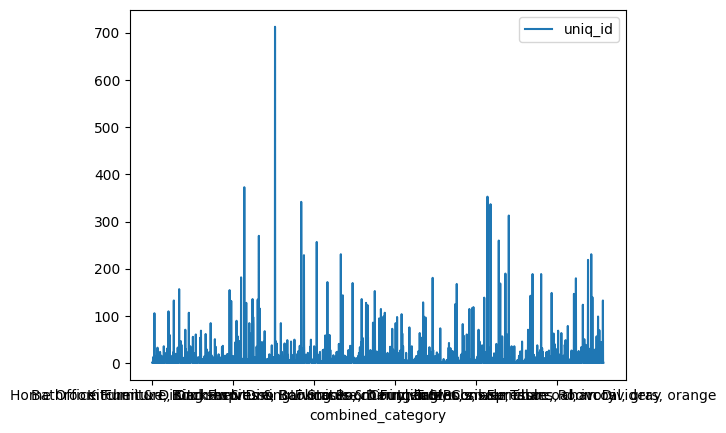

In [106]:
s1 = d1[["combined_category", "uniq_id"]].groupby("combined_category").count()
s1.plot()

In [107]:
s1[s1.uniq_id == s1.uniq_id.max()]

,uniq_id
combined_category,
"Home Office Furniture, Office Chairs, black",713


In [108]:
len(np.unique(d1["combined_category"]))

2790

In [109]:
s1.describe()

,uniq_id
count,2790.000000
mean,10.074552
std,30.556923
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,713.000000


In [114]:
d1["combined_title"] = d1.apply(combine_title, axis=1)

In [116]:
d1["combined_title"].iloc[0]

'Salinas Mission Desk & Hutch Antique White - Bush Furniture, white, MDF Composite (Medium-Density Fiberboard) (Frame) '

In [121]:
d2 = d1[["uniq_id", "combined_category", "combined_title"]]
d2.columns = ["uniq_id", "combined_category", "title"]
write_pickle(osp.join(pickle_path, f"meta_data.pkl"), d2)

In [118]:
cat_set = set(d1["combined_category"].values)

cat_list = []
ecat_list = []

for cat in cat_set:
    
    ecat = clip.tokenize(cat)
    cat_list.append(cat)
    ecat_list.append(ecat)
    
ecat_list = torch.cat(ecat_list).to(device)
with torch.no_grad():
    ecat_list = list(model.encode_text(ecat_list))

print(f"saving encoded categories")
df = pd.DataFrame(data={
    "category": cat_list,
    "encoded_category": ecat_list
})

write_pickle(osp.join(pickle_path, f"categories.pkl"), df)

saving encoded categories


In [119]:
title_set = set(d1["combined_title"].values)

title_list = []
etitle_list = []

for title in title_set:
    
    etitle = clip.tokenize(title)
    title_list.append(title)
    etitle_list.append(etitle)
    
res = []
chunk = 500
idx = 0
total_len = len(etitle_list)
while True:
    print(f"{round(idx*100/total_len, 2)}%")
    if idx >= len(etitle_list):
        break
    curr_list = torch.cat(etitle_list[idx:idx+chunk]).to(device)
    with torch.no_grad():
        curr_list = list(model.encode_text(curr_list))
        res += curr_list
    idx += chunk

print(f"saving encoded titles")
df = pd.DataFrame(data={
    "title": title_list,
    "encoded_title": res
})

write_pickle(osp.join(pickle_path, f"titles.pkl"), df)

0.0%
1.79%
3.58%
5.36%
7.15%
8.94%
10.73%
12.52%
14.31%
16.09%
17.88%
19.67%
21.46%
23.25%
25.04%
26.82%
28.61%
30.4%
32.19%
33.98%
35.77%
37.55%
39.34%
41.13%
42.92%
44.71%
46.5%
48.28%
50.07%
51.86%
53.65%
55.44%
57.23%
59.01%
60.8%
62.59%
64.38%
66.17%
67.96%
69.74%
71.53%
73.32%
75.11%
76.9%
78.69%
80.47%
82.26%
84.05%
85.84%
87.63%
89.42%
91.2%
92.99%
94.78%
96.57%
98.36%
100.15%
saving encoded titles


In [134]:
total_len = len(cat_set)
cidx = 0
printed_cidx = set()
for cat in cat_set:
    
    pct = int(round(cidx*100/total_len, 0))
    if pct % 10 == 0 and pct not in printed_cidx:
        print(f"{pct}%")
        printed_cidx.add(pct)
    
    cidx += 1
    
    store_path = osp.join(image_pickle_path, f"{cat}.pkl")
    if osp.exists(store_path):
        continue

    uid_list = []
    for idx, row in d1[d1["combined_category"] == cat].iterrows():
        uid = row.uniq_id
        uid_list.append(uid)

    image = torch.cat([preprocess(Image.open(image_path(uid))).unsqueeze(0) for uid in uid_list]).to(device)
    with torch.no_grad():
        eimage_list = list(model.encode_image(image))
        
    if len(uid_list) > 0:
        df = pd.DataFrame(data={
            "uid": uid_list,
            "encoded_image": eimage_list
        })
        write_pickle(store_path, df)

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
